In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
import math

def format_value_with_uncertainty(value, variance, sample_size):
    def round_to_one_significant(x):
        if x == 0:
            return 0.0
        exponent = np.floor(np.log10(abs(x)))
        mantissa = x / (10 ** exponent)
        rounded_mantissa = np.round(mantissa)
        if rounded_mantissa == 10:
            rounded_mantissa = 1
            exponent += 1
        return rounded_mantissa * (10 ** exponent)
    
    def get_decimal_places(x):
        s = "{0:.10f}".format(x).rstrip('0').rstrip('.')
        return len(s.split('.')[1]) if '.' in s else 0
    
    std_dev = np.sqrt(variance)
    standard_error = std_dev / np.sqrt(sample_size)
    
    if standard_error == 0:
        return f"{round(value):.0f} ± 0"
    
    rounded_uncertainty = round_to_one_significant(standard_error)
    decimal_places = get_decimal_places(rounded_uncertainty)
    
    formatted_value = round(value, decimal_places)
    formatted_uncertainty = round(rounded_uncertainty, decimal_places)
    
    return f"{formatted_value:.{decimal_places}f} ± {formatted_uncertainty:.{decimal_places}f}"

In [3]:
def print_hist_dencity(dist, plot_range, save_path):
    a = dict()
    a[10] = dist.rvs(10)
    a[50] = dist.rvs(50)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        if isinstance(dist.dist, stats.rv_continuous):
            ax.hist(a[num], bins=np.sqrt(num).astype(int), range=plot_range, density=True, color='blue', alpha=0.5)
            x = np.linspace(plot_range[0], plot_range[1], num=int(1e5))
            ax.plot(x, dist.pdf(x), color='red')
        else:
            x = np.arange(plot_range[0], plot_range[1])
            ax.hist(a[num], bins=min(np.sqrt(num).astype(int), (plot_range[1]-plot_range[0])), range=plot_range, density=True, color='blue', alpha=0.5)
            ax.plot(x, dist.pmf(x))
    if save_path:
        plt.savefig(save_path)
    plt.show()

def q_mid(x):
    return np.percentile(x, [75, 25]).mean()

def statistics(dist):
    stats = np.empty((3, 6, 1000))
    for i in range(1000):
        a = dict().fromkeys(range(3))
        a[0] = dist.rvs(10)
        a[1] = dist.rvs(100)
        a[2] = dist.rvs(1000)
        for j in range(3):
            stats[j, :3, i] = np.array([a[j].mean(), np.median(a[j]), q_mid(a[j])])
            stats[j, 3:, i] = stats[j, :3, i] ** 2
    ans = stats.mean(axis=2)
    ans[:, 3:] = ans[:, 3:]-ans[:,:3]**2
    ans = pd.DataFrame(ans, columns=['Mean','Median','$z_Q$', 'Mean variance','Median variance','$z_Q$ variance'])
    ans = pd.concat((pd.DataFrame(np.array([10, 100, 1000]), columns=['Sample size']), ans), axis=1)
    for i in range(3):
        ans['Mean'][i] = format_value_with_uncertainty(ans['Mean'][i], ans['Mean variance'][i], ans['Sample size'][i])
        ans['Median'][i] = format_value_with_uncertainty(ans['Median'][i], ans['Median variance'][i], ans['Sample size'][i])
        ans['$z_Q$'][i] = format_value_with_uncertainty(ans['$z_Q$'][i], ans['$z_Q$ variance'][i], ans['Sample size'][i])
    return ans[['Sample size', 'Mean', 'Median', '$z_Q$']]

In [4]:
def print_boxplot(dist, save_path=None):
    a = dict()
    a[10] = dist.rvs(20)
    a[50] = dist.rvs(100)
    a[1000] = dist.rvs(1000)
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    outliers = dict.fromkeys(a.keys())
    for num, ax in zip(a.keys(), axes):
        ax.set_title(f'Number of samples {num}')
        bplot = ax.boxplot(a[num])
        outliers[num] = len(bplot["fliers"][0].get_ydata())
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return outliers

In [5]:
class MixtureModel(stats.rv_continuous):
    def __init__(self, submodels, *args, weights = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        if weights is None:
            weights = [1 for _ in submodels]
        if len(weights) != len(submodels):
            raise(ValueError(f'There are {len(submodels)} submodels and {len(weights)} weights, but they must be equal.'))
        self.weights = [w / sum(weights) for w in weights]
        
    def pdf(self, x):
        pdf = self.submodels[0].pdf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            pdf += submodel.pdf(x)  * weight
        return pdf
            
    def _sf(self, x):
        sf = self.submodels[0].sf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            sf += submodel.sf(x)  * weight
        return sf

    def _cdf(self, x):
        cdf = self.submodels[0].cdf(x) * self.weights[0]
        for submodel, weight in zip(self.submodels[1:], self.weights[1:]):
            cdf += submodel.cdf(x)  * weight
        return cdf

        

    def rvs(self, size):
        submodel_choices = np.random.choice(range(len(self.submodels)), size=size, p = self.weights)
        submodel_samples = [submodel.rvs(size=size) for submodel in self.submodels]
        rvs = np.empty(submodel_samples[0].shape)
        for i, choice in enumerate(submodel_choices):
            rvs[i] = submodel_samples[choice][i]
        return rvs


In [6]:
def corr_statistics(dist):
    statistics = dict.fromkeys([20, 60, 100], {'Pearson Corr': np.empty(1000), 'Spearman Corr': np.empty(1000)})
    ans = dict.fromkeys([20, 60, 100], {'Pearson Corr': '', 'Spearman Corr': ''})
    for i in range(1000):
        a = {20: dist.rvs(20), 60: dist.rvs(60), 100: dist.rvs(100)}
        for j in a.keys():
            statistics[j]['Pearson Corr'][i] = stats.pearsonr(a[j][:, 0], a[j][:, 1]).statistic
            statistics[j]['Spearman Corr'][i] = stats.spearmanr(a[j][:, 0], a[j][:, 1]).statistic
    for k in statistics.keys():
        m = np.mean(statistics[k]['Pearson Corr'])
        v = np.var(statistics[k]['Pearson Corr'])
        ans[k]['Pearson Corr'] = format_value_with_uncertainty(m, v, k)
        m = np.mean(statistics[k]['Spearman Corr'])
        v = np.var(statistics[k]['Spearman Corr'])
        ans[k]['Spearman Corr'] = format_value_with_uncertainty(m, v, k)
    return ans

In [7]:
def plot_level_lines(dist, plot_range_x, plot_range_y, save_path):
    f = dist.pdf
    x, y = np.mgrid[plot_range_x[0]:plot_range_x[1]:0.01*(plot_range_x[1]-plot_range_x[0]), plot_range_y[0]:plot_range_y[1]:0.01*(plot_range_y[1]-plot_range_y[0])]
    pos = np.dstack((x, y))
    z = f(pos)
    plt.contour(x, y, z, levels=25)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [8]:
def LsS(x, y, true_a, true_b):
    a = ((x*y).mean()-(x.mean()*y.mean()))/((x**2).mean()-(x.mean())**2)
    b = y.mean()-x.mean()*a
    print(a, a/true_a, b, b/true_b)
    return a, a/true_a, b, b/true_b

In [9]:
from scipy.optimize import minimize

def LAV(x, y, true_a, true_b):
    def m_a_v(a, b):
        return np.abs(a*x+b-y).mean()
    w = minimize(lambda w: m_a_v(w[0], w[1]), (1, 1), method='Nelder-Mead').x
    print(w[0], w[0]/true_a, w[1], w[1]/true_b)
    return w[0], w[0]/true_a, w[1], w[1]/true_b

In [20]:
def chi_square_norm_test(samples, k, alpha):
    treshhold = stats.chi2.ppf(1-alpha, k-1)
    H_0_dist = stats.norm(*stats.norm.fit(samples))
    bins = np.linspace(H_0_dist.mean()-3*H_0_dist.std(), H_0_dist.mean()+3*H_0_dist.std(), k-1, endpoint=True)
    bins = np.append(bins, np.inf)
    bins = np.insert(bins, 0, -np.inf)
    P = H_0_dist.cdf(bins[1:])-H_0_dist.cdf(bins[:-1])
    freq = np.histogram(samples, bins)[0]
    statistics = ((freq-len(samples)*P)**2/(len(samples)*P))
    criterion = statistics.sum()
    if criterion >= treshhold:
        result = 'Reject'
    else:
        result = 'Fail to reject'
    table = pd.DataFrame(np.column_stack((bins[:-1].T, bins[1:], (bins[:-1]-H_0_dist.mean())/H_0_dist.std(), (bins[1:]-H_0_dist.mean())/H_0_dist.std(),
                         P, statistics)), columns=['Left Edge', 'Right Edge', 'NLeft Edge', 'NRight Edge', 'Probability', 'Stat'])
    return table, criterion, result

In [13]:
X = np.linspace(-1.8, 2, 20, endpoint=True)
eps = stats.norm.rvs(0, 1, size=20)
Y_1 = 2+2*X+eps
a_1, _, b_1, _ = LsS(X, Y_1, 2, 2)
a_2, _, b_2, _ = LAV(X, Y_1, 2, 2)

1.9214815323058927 0.9607407661529463 1.852721341598598 0.926360670799299
1.8896725603413382 0.9448362801706691 1.8959992773540275 0.9479996386770138


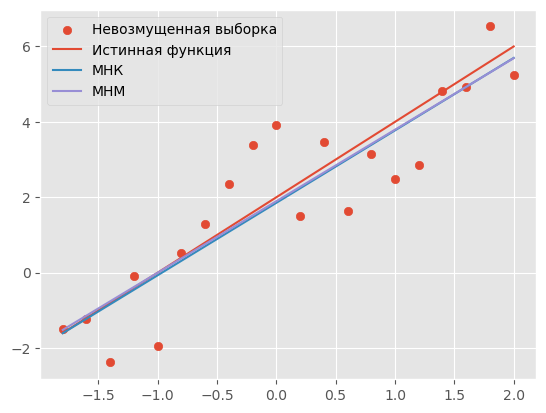

In [17]:
plt.scatter(X, Y_1, label='Невозмущенная выборка')
x = np.linspace(-1.8, 2, 1000, endpoint=True)
plt.plot(x, 2+2*x, label='Истинная функция')
plt.plot(x, b_1+a_1*x, label='МНК')
plt.plot(x, b_2+b_2*x, label='МНМ')
plt.legend()
plt.savefig('./images/41')
plt.show()

In [22]:
eps = stats.norm.rvs(0, 1, size=20)
Y_2 = 2+2*X+eps
Y_2[0] += 10
Y_2[-1] += -10
a_1, _, b_1, _ = LsS(X, Y_2, 2, 2)
a_2, _, b_2, _ = LAV(X, Y_2, 2, 2)

0.3574727994035336 0.1787363997017668 2.4793602021433814 1.2396801010716907
1.440542335907387 0.7202711679536935 2.4037495519256398 1.2018747759628199


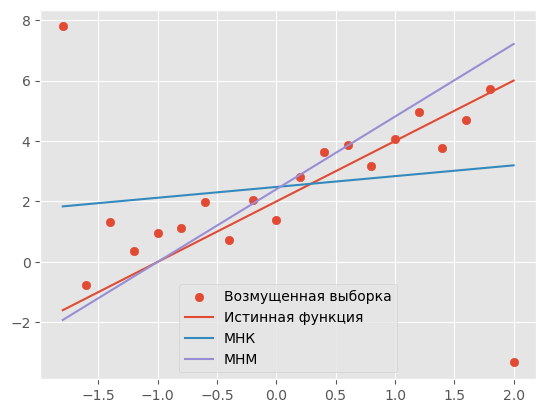

In [24]:
plt.scatter(X, Y_2, label='Возмущенная выборка')
x = np.linspace(-1.8, 2, 1000, endpoint=True)
plt.plot(x, 2+2*x, label='Истинная функция')
plt.plot(x, b_1+a_1*x, label='МНК')
plt.plot(x, b_2+b_2*x, label='МНМ')
plt.legend()
plt.savefig('./images/42')
plt.show()

In [45]:
X = stats.norm.rvs(0, 1, size=100)
table, criterion,  res = chi_square_norm_test(X, 10, 0.05)
print(res, criterion)
print(table.to_latex(index=False))

Fail to reject 6.230556471994799
\begin{tabular}{rrrrrr}
\toprule
Left Edge & Right Edge & NLeft Edge & NRight Edge & Probability & Stat \\
\midrule
-inf & -2.988818 & -inf & -3.000000 & 0.001350 & 0.134990 \\
-2.988818 & -2.264953 & -3.000000 & -2.250000 & 0.010875 & 0.765762 \\
-2.264953 & -1.541089 & -2.250000 & -1.500000 & 0.054583 & 1.183594 \\
-1.541089 & -0.817225 & -1.500000 & -0.750000 & 0.159820 & 0.992143 \\
-0.817225 & -0.093361 & -0.750000 & -0.000000 & 0.273373 & 0.016067 \\
-0.093361 & 0.630503 & -0.000000 & 0.750000 & 0.273373 & 0.259359 \\
0.630503 & 1.354368 & 0.750000 & 1.500000 & 0.159820 & 1.553025 \\
1.354368 & 2.078232 & 1.500000 & 2.250000 & 0.054583 & 1.183594 \\
2.078232 & 2.802096 & 2.250000 & 3.000000 & 0.010875 & 0.007034 \\
2.802096 & inf & 3.000000 & inf & 0.001350 & 0.134990 \\
\bottomrule
\end{tabular}



In [46]:
X = stats.uniform.rvs(-3, 6, size=20)
table, criterion,  res = chi_square_norm_test(X, 10, 0.05)
print(res, criterion)
print(table.to_latex(index=False))

Fail to reject 4.721604399020876
\begin{tabular}{rrrrrr}
\toprule
Left Edge & Right Edge & NLeft Edge & NRight Edge & Probability & Stat \\
\midrule
-inf & -4.746440 & -inf & -3.000000 & 0.001350 & 0.026998 \\
-4.746440 & -3.567086 & -3.000000 & -2.250000 & 0.010875 & 0.217491 \\
-3.567086 & -2.387732 & -2.250000 & -1.500000 & 0.054583 & 0.755817 \\
-2.387732 & -1.208379 & -1.500000 & -0.750000 & 0.159820 & 0.202030 \\
-1.208379 & -0.029025 & -0.750000 & -0.000000 & 0.273373 & 1.113558 \\
-0.029025 & 1.150329 & -0.000000 & 0.750000 & 0.273373 & 0.051872 \\
1.150329 & 2.329682 & 0.750000 & 1.500000 & 0.159820 & 1.017695 \\
2.329682 & 3.509036 & 1.500000 & 2.250000 & 0.054583 & 1.091655 \\
3.509036 & 4.688389 & 2.250000 & 3.000000 & 0.010875 & 0.217491 \\
4.688389 & inf & 3.000000 & inf & 0.001350 & 0.026998 \\
\bottomrule
\end{tabular}



In [53]:
X = stats.uniform.rvs(-3, 6, size=100)
table, criterion,  res = chi_square_norm_test(X, 10, 0.05)
print(res, criterion)
print(table.to_latex(index=False))

Fail to reject 7.3724104565705915
\begin{tabular}{rrrrrr}
\toprule
Left Edge & Right Edge & NLeft Edge & NRight Edge & Probability & Stat \\
\midrule
-inf & -4.902048 & -inf & -3.000000 & 0.001350 & 0.134990 \\
-4.902048 & -3.678188 & -3.000000 & -2.250000 & 0.010875 & 1.087457 \\
-3.678188 & -2.454329 & -2.250000 & -1.500000 & 0.054583 & 0.053766 \\
-2.454329 & -1.230469 & -1.500000 & -0.750000 & 0.159820 & 1.575532 \\
-1.230469 & -0.006610 & -0.750000 & 0.000000 & 0.273373 & 0.199830 \\
-0.006610 & 1.217250 & 0.000000 & 0.750000 & 0.273373 & 1.469091 \\
1.217250 & 2.441109 & 0.750000 & 1.500000 & 0.159820 & 1.575532 \\
2.441109 & 3.664969 & 1.500000 & 2.250000 & 0.054583 & 0.053766 \\
3.664969 & 4.888828 & 2.250000 & 3.000000 & 0.010875 & 1.087457 \\
4.888828 & inf & 3.000000 & inf & 0.001350 & 0.134990 \\
\bottomrule
\end{tabular}



In [52]:
X = stats.uniform.rvs(-3, 6, size=1000)
table, criterion,  res = chi_square_norm_test(X, 10, 0.05)
print(res, criterion)
print(table.to_latex(index=False))

Reject 91.58963847245896
\begin{tabular}{rrrrrr}
\toprule
Left Edge & Right Edge & NLeft Edge & NRight Edge & Probability & Stat \\
\midrule
-inf & -5.191484 & -inf & -3.000000 & 0.001350 & 1.349898 \\
-5.191484 & -3.894217 & -3.000000 & -2.250000 & 0.010875 & 10.874575 \\
-3.894217 & -2.596950 & -2.250000 & -1.500000 & 0.054583 & 0.754476 \\
-2.596950 & -1.299683 & -1.500000 & -0.750000 & 0.159820 & 20.457590 \\
-1.299683 & -0.002416 & -0.750000 & 0.000000 & 0.273373 & 13.332923 \\
-0.002416 & 1.294851 & 0.000000 & 0.750000 & 0.273373 & 7.866268 \\
1.294851 & 2.592118 & 0.750000 & 1.500000 & 0.159820 & 24.191778 \\
2.592118 & 3.889385 & 1.500000 & 2.250000 & 0.054583 & 0.537658 \\
3.889385 & 5.186652 & 2.250000 & 3.000000 & 0.010875 & 10.874575 \\
5.186652 & inf & 3.000000 & inf & 0.001350 & 1.349898 \\
\bottomrule
\end{tabular}

